# GenCFD 2D Demo

This demo showcases how the GenCFD diffusion model can be used as a surrogate model to solve the 2D wave equation, utilizing a sine basis representation. The wave equation is a second-order linear partial differential equation (PDE) that describes the evolution of waves or standing wave fields. Examples include sound waves, seismic waves, or other wave-like phenomena arising in fields such as acoustics, electromagnetism, or fluid dynamics.

In this setting, the wave equation is a hyperbolic PDE described as a scalar function in both space and time. For fluid dynamics, the quantity of interest is often represented as

$$
u = u(x,y,t).
$$

Here u(x,y,t) represents physical quantities in scalar fields, such as pressure or displacement. The governing equation for these fields is

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) ,
$$

where:

- c: A fixed, non-negative real coefficient representing the wave propagation speed,
- u: The scalar quantity of interest,
- x,y: Spatial coordinates,
- t: Time.

This problem is fundamental in physics and engineering and serves as a building block for understanding more complex wave dynamics. In this demo, the GenCFD diffusion model acts as a surrogate to approximate the solution efficiently by leveraging the sine basis representation.

For more information, visit the [Wave Equation](https://en.wikipedia.org/wiki/Wave_equation)

### Install GenCFD as a Library

To use GenCFD as a library, you can install it directly from its GitHub repository. Before proceeding, ensure that you are working within a conda or virtual environment to manage dependencies effectively and avoid conflicts. Once the environment is set up, run the following command.

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import sys
sys.executable

'/cluster/home/lcarretero/python_envs/rds-misc/bin/python'

In [3]:
import site
print(site.getsitepackages())

['/cluster/home/lcarretero/python_envs/rds-misc/lib/python3.11/site-packages', '/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages']


In [4]:
sys.path.append(r'/cluster/home/lcarretero/workspace/rds/GenCFD')
import GenCFD

In [5]:
# Setup relevant libraries
import os
import warnings
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pylab as plt

from torch import optim
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, Union

import GenCFD
from GenCFD import diffusion as dfn_lib
from GenCFD import model, train, solvers, utils

Tensor = torch.Tensor
array = np.ndarray

DATA_STD = 0.5 # Fixed parameter but can also be learnable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 0

# Setting global seed for reproducibility
torch.manual_seed(SEED)  # For CPU operations
torch.cuda.manual_seed(SEED)  # For GPU operations
torch.cuda.manual_seed_all(SEED)  # Ensure all GPUs (if multi-GPU) are set


2025-03-25 21:11:19.060151: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-25 21:11:23.412749: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-25 21:11:39.190539: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### 2D Wave Equation

In this demo, we solve the 2D wave equation using a sine basis representation. Below we detail the generation of the sine basis, the matrix describing the wave modes, and the analytical solution of the wave equation.

1. Sine Basis Generation

The sine basis is used to represent the solution as a sum of sinusoidal components. Each basis function corresponds to a specific mode (i,j), representing:

$$
\sin(\pi i x) \sin(\pi j y) .
$$

These functions are evaluated on a uniform grid of size s x s. The following function generates the sine basis of shape (K, K, s, s) where K is the number of modes in each spatial dimension.

In [6]:
# Generate Sine basis B of the shape (K, K, s, s)
# For each mode (i,j), B[i,j] represents the function 
# sin(np.pi*i*x)*np.sin(np.pi*j*y) evaluated at the s*s uniform grid
def generate_sine_basis(K = 16, s = 128):
    xx,yy = np.meshgrid(np.arange(s), np.arange(s), indexing="ij")
    xx = xx/s
    yy = yy/s
    sine_basis  = np.zeros((K,K,s,s))
    for i in range(1,K+1):
        for j in range(1,K+1):  
            sine_basis[i-1,j-1] = np.sin(np.pi*i*xx)*np.sin(np.pi*j*yy)
    return sine_basis

2. Wave Mode Matrix

To capture the frequency and decay properties of the wave equation, a square matrix is generated where each element (i,j) corresponds to:

$$
(i+1)^2 + (j+1)^2
$$

This matrix is essential for determining the mode-dependent contributions to the solution.

In [7]:
def generate_square_matrix(K=16):
    M = np.zeros((K, K))
    for i in range(1, K + 1):
        for j in range(1, K + 1):
            M[i - 1, j - 1] = i**2 + j**2
    return M

3. Analytical Solution of the 2D Wave Equation

The analytical solution is computed using the sine basis and wave mode matrix. The scalar field u(x,y,t) is represented as a summation of sinusoidal components, modulated by coefficients, decay terms, and time-dependent oscillations:

- f(x,y): Initial condition of the wave equation.
- u(x,y,t): Solution at a given time t.

In [8]:
# Analytical solution of 2d Wave equation
def generate_solution_wave(coeff, time, sine_basis, square_matrix, K = 16, decay = 0.8, c = 0.1):
    multiplier_f = coeff * np.power(square_matrix, decay)
    multiplier_f = multiplier_f.reshape(K, K , 1, 1)
    f = np.pi*np.sum(multiplier_f * sine_basis, axis = (0,1))

    square_matrix_time = np.cos(c * np.pi * time * np.sqrt(square_matrix))
    multiplier_u = coeff * np.power(square_matrix, decay) * square_matrix_time
    multiplier_u = multiplier_u.reshape(K, K , 1, 1)
    u = np.pi*np.sum(multiplier_u * sine_basis, axis = (0,1))

    return f, u

### Micro-Macro Perturbations

GenCFD has demonstrated the ability to capture not only statistical patterns but also make accurate predictions for out-of-distribution scenarios. To evaluate this capability, GenCFD is tested on a dataset generated with small perturbations in the initial conditions - perturbations it has never encountered during training.

these minor variations in the initial conditions can lead to significant changes in the target solution, a characteristic commonly observed in turbulent flows and chaotic systems. Consequently, this dataset is exclusively used for inference and validation, highlighting GenCFD's robustness in handling unpredictable and dynamic scenarios.

In [9]:
# Generation of micro-macro perturbations
def generate_perturbation_wave(coeff, time, sine_basis, square_matrix, K = 16, decay = 0.8, c =0.1, perturbation = 0.25):
    p_matrix = np.random.uniform(-perturbation, perturbation, (K, K))
    return generate_solution_wave(coeff+p_matrix , time, sine_basis, square_matrix, K = K, decay = decay, c = c)

### Data Generation for Training and Evaluation

The generate_training_data function creates a dataset of input-output pairs for training the model, while the generate_micro_macro_data function generates datasets with micro and macro perturbations for evaluating the model's robustness to chaotic and turbulent scenarios.

In [10]:
def generate_training_data(c = 0.1, time = 5.0, N_data = 1024, K = 24, decay = -0.8, s = 128):
    sine_basis = generate_sine_basis(K, s)
    square_matrix = generate_square_matrix(K)

    inputs = np.zeros((N_data, s, s))
    targets = np.zeros((N_data, s, s))
    
    for n in range(N_data):
        coeff = np.random.uniform(-1,1, (K, K))
        inp, out = generate_solution_wave(coeff, time, sine_basis, square_matrix, K = K, decay = decay, c = c)
        inputs[n] = inp
        targets[n] = out

        if n%20 == 0:
            print(f"Done {n+1} out of {N_data}")
        
    print(" ")

    return inputs, targets

def generate_micro_macro_data(coeff_macro, perturbation = 0.25, c = 0.1, time = 5.0, N_data = 1024, K = 24, decay = -0.8, s = 128):
    sine_basis = generate_sine_basis(K, s)
    square_matrix = generate_square_matrix(K)

    inputs = np.zeros((N_data, s, s))
    targets = np.zeros((N_data, s, s))
    
    for n in range(N_data):
        inp, out = generate_perturbation_wave(coeff_macro, time, sine_basis, square_matrix, K = K, decay = decay, c = c, perturbation = perturbation)
        inputs[n] = inp
        targets[n] = out

        if n%20 == 0:
            print(f"Done {n+1} micro out of {N_data}")

    print(" ")

    return inputs, targets


Done 1 out of 32
Done 21 out of 32
 
(32, 128, 128) (32, 128, 128)


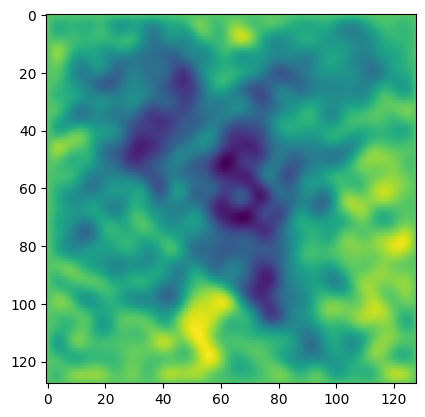

In [39]:
inputs, targets = generate_training_data(N_data=32)
print(inputs.shape, targets.shape)
plt.imshow(targets[3])

Generation of training and evaluation samples. Defining key parameters for the wave equation simulation.

In [11]:
K = 24
# It's possible to choose a smaller resolution s, e.g. 64
s = 128
decay = -0.8
c = 0.1
time = 5.0
N_data = 128

inp_train, out_train = generate_training_data(c = c, time = time, N_data = N_data, K = K, decay =decay, s = s)

N_data_macro = 128
perturbation = 0.25
coeff_macro = np.random.uniform(-1,1, (K, K))

inp_micro, out_micro = generate_micro_macro_data(coeff_macro, perturbation = perturbation, c = c, time = time, N_data = N_data_macro, K = K, decay = decay, s = s)


Done 1 out of 128
Done 21 out of 128
Done 41 out of 128
Done 61 out of 128
Done 81 out of 128
Done 101 out of 128
Done 121 out of 128
 
Done 1 micro out of 128
Done 21 micro out of 128
Done 41 micro out of 128
Done 61 micro out of 128
Done 81 micro out of 128
Done 101 micro out of 128
Done 121 micro out of 128
 


In [40]:
inp_micro.shape, out_micro.shape

((128, 128, 128), (128, 128, 128))

### Visuzalization

The Initial Condition represents the input to the model, while the Solution repersents the target output that the model aims to predict.

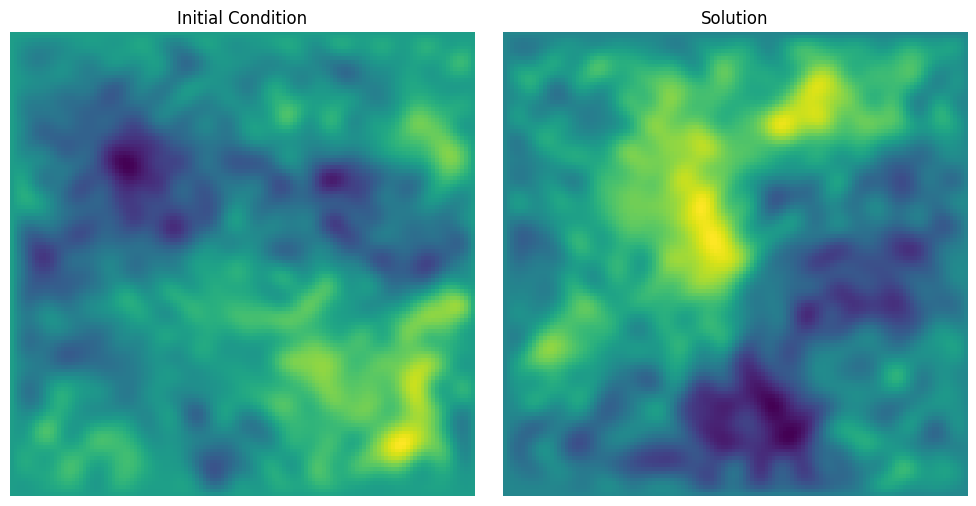

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(inp_train[0,...])
axes[0].set_title("Initial Condition")
axes[0].axis("off")

axes[1].imshow(out_train[0,...])
axes[1].set_title("Solution")
axes[1].axis("off")

plt.tight_layout()
plt.show()

The BaseDataset class serves as a foundation for managing both training and evaluation datasets. It standardizes data input/output for consistent model training and inference.

In [13]:
class BaseDataset:
    """
    Base class for Inference and Training. 

    Args:
        input_data: Training Input Dataset, typically includes the initial conditions
        output_data: Ground Truth (GT), Output Dataset, is the solution to the given problem
        mode: Decision whether the given data is used for inference or training thus only 2 options ['training', 'evaluation']
        input_channel: Number of input channels (from train_data)
        output_channel: Number of channels that should be predicted by the Diffusion Model
        spatial_resolution: Resolution of the input and output dataset
        input_shape: Shape of the input data tensor. Depends on the conditioning you use
        output_shape: This should be equal to (output_channel, spatial_resolution)
        ndim: Dimensionality of the dataset. Here we have a 2D dataset
        training_samples: Number of samples available in the dataset
        mean_training_input: Array with relevant mean values for each channel of the input dataset
        std_training_input: Array with relevant std values for each channel of the input dataset
        mean_training_output: Array with relevant mean values for each channel of the output dataset
        std_training_output: Array with relevant std values for each channel of the output dataset
    """
    def __init__(
            self, 
            input_data: Dataset,
            output_data: Dataset,
            mode: str,
            input_channel: int,
            output_channel: int,
            spatial_resolution: Tuple,
            input_shape: Tuple,
            output_shape: Tuple,
            ndim: int = 2,
            training_samples: int = None,
            mean_training_input: array = None,
            std_training_input: array = None,
            mean_training_output: array = None,
            std_training_output: array = None
        ) -> None:

        assert mode in ['training', 'evaluation'], f'mode can either be training or evaluation not {mode}'

        self.initial_cond = input_data
        self.target_cond = output_data
        self.mode = mode
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.spatial_resolution = spatial_resolution
        self.input_shape = input_shape,
        self.output_shape = output_shape,
        self.ndim = ndim,
        self.training_samples = training_samples
        self.mean_training_input = mean_training_input
        self.std_training_input = std_training_input
        self.mean_training_output = mean_training_output
        self.std_training_output = std_training_output


    def normalize(self, u_: Union[array, Tensor], which: str) -> Union[array, Tensor]:
        """Standardization of data can be done for torch tensors or numpy arrays
        
        args:
            u_:     Container which should be standardized by subtracting the mean and dividing through the std
            which:   decision whether to use the input or output normalization parameters (mean and std) 
        """

        assert which in ['input', 'output']

        if self.mean_training_input is not None:
            mean_training_input = self.mean_training_input if which == 'input' else self.mean_training_output
            std_training_input = self.std_training_input if which == 'input' else self.std_training_output
            if isinstance(u_, Tensor):
                mean_training_input = torch.as_tensor(
                    mean_training_input, dtype=u_.dtype, device=u_.device
                )
                std_training_input = torch.as_tensor(
                    std_training_input, dtype=u_.dtype, device=u_.device
                )
            return (u_ - mean_training_input) / (std_training_input + 1e-12)
        else:
            return u_
    

    def __len__(self):
        return self.training_samples
    
    
    def __getitem__(self, index: int) -> dict:
        
        initial_cond = self.initial_cond[index, ...].reshape((*self.spatial_resolution, 1))
        target_cond = self.target_cond[index, ...].reshape((*self.spatial_resolution, 1))

        if self.mode == 'training':
            initial_cond = self.normalize(initial_cond, 'input')
            target_cond = self.normalize(target_cond, 'output')
        
        # The data should be in the form (channel, y, x)
        initial_condition = (
            torch.from_numpy(initial_cond)
            .type(torch.float32)
            .permute(2, 1, 0)
        )

        target_condition = (
            torch.from_numpy(target_cond)
            .type(torch.float32)
            .permute(2, 1, 0)
        )

        return {
            'initial_cond': initial_condition,
            'target_cond': target_condition
        }


mean_training_input = inp_train.mean()
std_training_input = inp_train.std()
mean_training_output = out_train.mean()
std_training_output = out_train.std()

batch_size = 5
in_channels = 1 # number of channels of the initial condition
out_channels = 1 # number of channels to predict
spatial_resolution = (s, s) # (128, 128)
input_shape = (2, s, s) # due to conditioning of the diff model on intitial cond
output_shape = (out_channels, s, s) 


train_dataset = BaseDataset(
    input_data=inp_train,
    output_data=out_train,
    mode='training',
    input_channel=in_channels,
    output_channel=out_channels,
    spatial_resolution=spatial_resolution, # (128, 128)
    input_shape=input_shape,
    output_shape=output_shape,
    ndim=2,
    training_samples=N_data, # 128 samples
    mean_training_input=mean_training_input,
    std_training_input=std_training_input,
    mean_training_output=mean_training_output,
    std_training_output=std_training_output
)

evaluation_dataset = BaseDataset(
    input_data=inp_micro,
    output_data=out_micro,
    mode='evaluation',
    input_channel=in_channels,
    output_channel=out_channels,
    spatial_resolution=spatial_resolution, 
    input_shape=input_shape,
    output_shape=output_shape,
    ndim=2,
    training_samples=N_data, 
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

evaluation_dataloader = DataLoader(
    dataset=evaluation_dataset,
    batch_size=batch_size,
    shuffle=True
)

### Model Construction

Section describes the creation and configuration of the denoising model, which consists of a UNet-based Preconditioned Denoiser wrapped within a diffusion framework for generating samples. To enhance performance, the model can be compiled using torch.compile. This provides faster training and inference, particularly on GPUs.

Note: Some GPUs may produce warnings during compilation. These warnings can safely be ignored. For the following GPUs no Warnings were observed:
- NVIDIA GeForce RTX 2080 Ti
- NVIDIA GeForce RTX 3090
- NVIDIA GeForce RTX 4090
- NVIDIA Tesla A100

In [41]:
denoiser = model.PreconditionedDenoiser(
    in_channels=in_channels + out_channels, # Conditioning thus stacked input and output
    out_channels=out_channels,
    spatial_resolution=spatial_resolution,
    time_cond=False,
    num_channels=(64, 128),
    downsample_ratio=(2, 2),
    num_blocks=4,
    noise_embed_dim=128,
    output_proj_channels=128,
    input_proj_channels=128,
    padding_method='circular',
    dropout_rate=0.0,
    use_attention=True,
    use_position_encoding=True,
    num_heads=8,
    normalize_qk=False,
    dtype=torch.float32,
    device=device,
    sigma_data=DATA_STD
)

# Optional: compile the model for fast training and inference
is_compiled = True
if torch.cuda.is_available() and is_compiled:
    denoiser = torch.compile(denoiser)
    # For some GPUs there will appear Warnings, if that's the case 
    # these can be ignored.
    warnings.filterwarnings("ignore") 

diffusion_scheme = dfn_lib.Diffusion.create_variance_exploding(
    sigma=dfn_lib.tangent_noise_schedule(device=device),
    data_std=DATA_STD,
)

denoising_model = dfn_lib.DenoisingModel(
    spatial_resolution=spatial_resolution,
    time_cond=False,
    denoiser=denoiser,
    noise_sampling=dfn_lib.log_uniform_sampling(
        diffusion_scheme, 
        clip_min=1e-4, 
        uniform_grid=True, 
        device=device
    ),
    noise_weighting=dfn_lib.edm_weighting(
        data_std=DATA_STD, 
        device=device
    ),
    consistent_weight=0.0,
    device=device,
    dtype=torch.float32
)

# Print number of Parameters:
model_params = sum(
    p.numel() for p in denoising_model.denoiser.parameters() if p.requires_grad
)

print(f"Total number of model parameters: {model_params}")

Total number of model parameters: 5599233


The DenoisingTrainer handles the training process for the denoising model. It includes features like Exponential Moving Average (EMA), which is crucial for stabilizing training and should always be enabled for consistent and reliable inference. Additionally, mixed precision training is utilized to optimize memory usage and computational efficiency by leveraging float16 or bfloat16 precision, making it ideal for modern GPUs and large-scale models.

In [42]:

trainer = train.DenoisingTrainer(
    model=denoising_model,
    optimizer=optim.AdamW(
        denoising_model.denoiser.parameters(),
        lr=1e-4,
        weight_decay=0.01,
    ),
    device=device,
    ema_decay=0.999,
    store_ema=True,
    track_memory=False,
    use_mixed_precision=True,
    is_compiled=is_compiled
)

The following command launches the training, where metric_aggregation_steps specifies the interval, in terms of iteration steps, after which metrics like loss or the standard deviation of the loss should be computed.

In [44]:
num_train_steps = 2_000

train.run_training(
    train_dataloader=train_dataloader,
    trainer=trainer,
    workdir=str(r'/cluster/home/lcarretero/workspace/rds/GenCFD/colab'),
    # DDP configs (not used here thuse set to 1)
    world_size=1,
    local_rank=-1,
    # Training configs
    total_train_steps=num_train_steps,
    # Since the dataset is small, metric aggregation after every epoch
    metric_aggregation_steps=N_data // batch_size, 
    # Callbacks
    callbacks=(
        # Save model at every checkpoint or at the end of the training
        train.callbacks.TrainStateCheckpoint(
            base_dir=str(r'/cluster/home/lcarretero/workspace/rds/GenCFD/colab'),
            save_every_n_step=num_train_steps # only save one model at the end
        ),
        # Display training progress in a tqdm bar
        train.callbacks.TqdmProgressBar(
            total_train_steps=num_train_steps,
            train_monitors=["loss",]
        )
    )
)

Continue Training from Checkpoint


  0%|          | 0/2000 [00:00<?, ?step/s]/scratch/tmp.27415682.lcarretero/tmpgxuhos0w/main.c:5:10: fatal error: Python.h: No such file or directory
    5 | #include <Python.h>
      |          ^~~~~~~~~~
compilation terminated.
/scratch/tmp.27415682.lcarretero/tmpzbj0jfcd/main.c:5:10: fatal error: Python.h: No such file or directory
    5 | #include <Python.h>
      |          ^~~~~~~~~~
compilation terminated.
/scratch/tmp.27415682.lcarretero/tmp_u1uiyh8/main.c:5:10: fatal error: Python.h: No such file or directory
    5 | #include <Python.h>
      |          ^~~~~~~~~~
compilation terminated.
/scratch/tmp.27415682.lcarretero/tmpoq7mte8q/main.c:5:10: fatal error: Python.h: No such file or directory
    5 | #include <Python.h>
      |          ^~~~~~~~~~
compilation terminated.
/scratch/tmp.27415682.lcarretero/tmpaf9ii5c3/main.c:5:10: fatal error: Python.h: No such file or directory
    5 | #include <Python.h>
      |          ^~~~~~~~~~
compilation terminated.
/scratch/tmp.27415682.l

KeyboardInterrupt: 

### Inference

The model's latest checkpoint is restored from the specified directory. Relevant is to load the EMA model parameters for inference on the macro-micro perturbed dataset.

In [21]:
model_path = os.path.join(r'/cluster/home/lcarretero/workspace/rds/GenCFD/colab','checkpoints')
latest_model_path = utils.get_latest_checkpoint(model_path)

trained_state = train.TrainState.restore_from_checkpoint(
    latest_model_path,
    model=denoising_model.denoiser,
    optimizer=trainer.optimizer,
    is_compiled=trainer.is_compiled,
    is_parallelized=False,
    use_ema=True,
    device=device,
)

### Solving the Stochastic Differential Equation

These functions are necessary to solve the stochastic differential equation (SDE), as the diffusion model predicts the score function. To solve this equation the Euler-Maruyama method is employed for numerical integration while the EDM noise decay function defines the time span and noise schedule. The sampler then uses these components to generate the resulting sample.

In [22]:

denoise_fn = trainer.inference_fn_from_state_dict(
    trained_state,
    denoiser=denoising_model.denoiser,
    lead_time=False,
)

integrator = solvers.EulerMaruyama(
    time_axis_pos=0,
    terminal_only=True
)

tspan = dfn_lib.edm_noise_decay(
    scheme=diffusion_scheme,
    rho=7,
    # Minimum of 30 steps required
    num_steps=128,
    end_sigma=1e-3,
    dtype=torch.float32,
    device=device
)

sampler = dfn_lib.SdeSampler(
    input_shape=output_shape,
    scheme=diffusion_scheme,
    denoise_fn=denoise_fn,
    tspan=tspan,
    integrator=integrator,
    guidance_transforms= (),
    apply_denoise_at_end=True,
    return_full_paths=False,
    device=device,
    dtype=torch.float32
)

Generate and visualize resulting sample

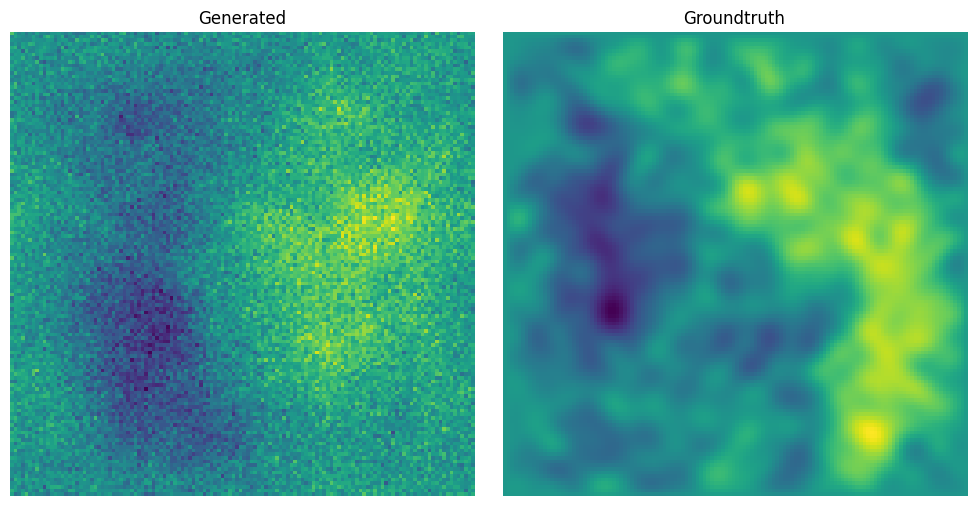

In [24]:
batch = next(iter(evaluation_dataloader))  # uniform random distribution
batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
u0 = batch["initial_cond"]
u = batch["target_cond"]

# No lead_time required since model wasn't conditioned on time
lead_time = [None] * batch_size

gen_samples = sampler.generate(
    num_samples=batch_size,
    y=u0,
    lead_time=lead_time,
).detach()

utils.plot_2d_sample(
    gen_sample=gen_samples[0], 
    gt_sample=u[0], 
    axis=0, 
    save=False, 
    save_dir=str(r'/cluster/home/lcarretero/workspace/rds/GenCFD/colab')
)